The plan for this project is to see if techniques in persistent homology can be leveraged to detect LLM-authored essays.

Mathematically, the homology of a topological space (for instance, a curve or surface) expresses how many "holes" it has, and of what dimension. 0-dimensional homology classes correspond to connected components, 1-dimensional classes to non-contractible loops, 2-dimensonal classes to voids, and so on.

Persistent homology is a relatively new computational technique. The idea is to begin with a point cloud, and then obtain a sequence of topological spaces by including progressively larger and larger radii around each point.
At the start, with radius 0, we get many 0-dimensional classes, one for each point. As the radius increases, connected components merge and 0-classes die; points may link into a loop, giving birth to a 1-dimensional class, which then dies as the radius becomes larger than the loop.

Through this method, we come up with an encoding the point clouds's global geometry.

Xiaojin Zhu, in [this paper](https://pages.cs.wisc.edu/~jerryzhu/pub/homology.pdf), uses this technique in an NLP setting. He specifically uses persistent homology to identify when a document returns to a topic it has already discussed, which appears as a 1-dimensional homology class. He uses this as a flag for "structurally richer" writing, that references previous points in order to build a more cohesive argument.

I intend to investigate how LLM- and human-authored essays differ with respect to this metric.
In practice, I may not be able to do much actual model training - computing persistent homology is computationally expensive, and computing them for an entire dataset could be very impractical. But the opportunity to play with a new tool (especially one that ties in to my math background so directly) seems fun!

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("thedrcat/daigt-v2-train-dataset")
print("Path to dataset files:", path)
filename = 'train_v2_drcat_02.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
tqdm.pandas()

import spacy
from spacy.language import Language
from spacy.lang.en import English
from spacy.tokens import Doc


import ripser
import persim

Path to dataset files: /Users/kaveh/.cache/kagglehub/datasets/thedrcat/daigt-v2-train-dataset/versions/2


In [2]:
data_filepath = os.path.join(path, filename)
essays = pd.read_csv(data_filepath)
essays.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [3]:
# Build spacy pipeline. Remove components of the default pipeline we don't need for performance, and add components to remove stopwords and punctuation.

nlp = spacy.load('en_core_web_md', exclude=['ner', 'parser'])

@Language.component('stopword_dropper')
def stopword_dropper(doc):
    new_words = [token.text for token in doc if not (token.is_stop or token.is_space or token.is_punct)]
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc

nlp.add_pipe('stopword_dropper', first=True)

<function __main__.stopword_dropper(doc)>

In [4]:
essays['text_spacy'] = essays['text'].progress_apply(nlp)
essays.head()

100%|██████████| 44868/44868 [17:48<00:00, 42.01it/s]


,text,label,prompt_name,source,RDizzl3_seven,text_spacy
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,"(Phones, Modern, humans, today, phone, phone, ..."
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,"(essay, explain, drivers, able, use, electroni..."
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,"(Driving, use, cellular, devices, Today, socie..."
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,"(Phones, Driving, Drivers, able, use, phones, ..."
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,"(Cell, Phone, Operation, Driving, ability, sta..."


In [5]:
# Some rudimentary testing to play around with the persistent homology package.
# First try: Use a sliding window to create a point cloud.
def pm_from_sliding_window(doc, window_size):
    length = len(doc)
    data = [doc[i:i+window_size] for i in range(length - window_size)]
    n = len(data)
    dm = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            sim = 1-data[i].similarity(data[j])
            dm[i, j] = sim
            dm[j, i] = sim
    pm = ripser.ripser(dm, distance_matrix=True)
    return pm

window_size = 15
essays['H_sw'] = essays['text_spacy'].progress_apply(lambda x : pm_from_sliding_window(x, window_size))

 86%|████████▌ | 38530/44868 [2:51:37<10:28, 10.09it/s]   /var/folders/pj/d1crch5j30s__4vxlk7nq4140000gn/T/ipykernel_12332/2210370782.py:10: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  sim = 1-data[i].similarity(data[j])
100%|██████████| 44868/44868 [3:13:56<00:00,  3.86it/s]  


In [6]:
essays['H_sw'].to_csv('essays_pm.csv')

/var/folders/pj/d1crch5j30s__4vxlk7nq4140000gn/T/ipykernel_12332/2123802246.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


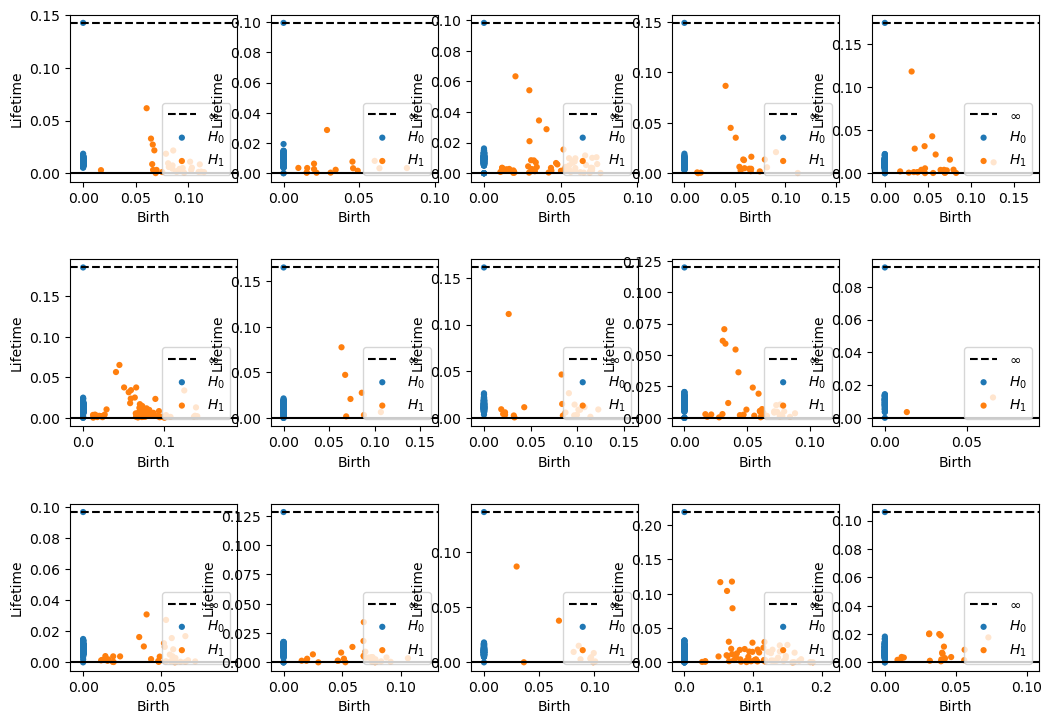

In [ ]:
def sample_pms(rows, cols, df):
    samples = df.sample(rows*cols)
    fig, axs_array = plt.subplots(rows, cols, figsize = (cols*2.5, rows*3))
    axs = axs_array.flatten()
    i = 0
    for ax in axs:
        essay = samples.iloc[i]
        pm = essay['H_sw']
        persim.plot_diagrams(pm['dgms'], ax=ax, lifetime=True)
        i += 1
    fig.show()

sample_pms(3, 5, essays)

In [10]:
essays['H_sw'][0]['dgms'][1]

array([[0.14111435, 0.14273417],
       [0.13524717, 0.16271317],
       [0.13383001, 0.13401723],
       [0.10353237, 0.1040802 ],
       [0.08464634, 0.08934534],
       [0.06886786, 0.18732548],
       [0.06174827, 0.06228989],
       [0.060188  , 0.06076258],
       [0.06017655, 0.06276596],
       [0.05943364, 0.06299037],
       [0.04558653, 0.0668425 ],
       [0.03872538, 0.06373566],
       [0.02065444, 0.02097327],
       [0.01826131, 0.02084267],
       [0.0159561 , 0.01812959],
       [0.01264608, 0.01818538]])

In [12]:
# One possible metric to extract from this: Total "survival time" of the H1 homology classes.
def tot_survival_time(pm):
    h1_classes = pm['dgms'][1]
    lifetimes = [a[1] - a[0] for a in h1_classes]
    return sum(lifetimes)

essays['tot_survival_time'] = essays['H_sw'].apply(tot_survival_time)

In [ ]:
from scipy.stats import f_oneway

humans = essays['tot_survival_time'][essays.label == 0]
machine = essays['tot_survival_time'][essays.label == 1]
print("Human mean H_1 survival time:", humans.mean(), humans.std())
print("Machine mean H_1 survival time:", machine.mean(), machine.std())

f_oneway(humans, machine)
#Statistically significant, but the standard deviations are very large - probably not a very good distinguisher.

Human mean H_1 survival time: 0.2649018270298411 0.21243060902645639
Machine mean H_1 survival time: 0.21466738717681497 0.13928163001944718


F_onewayResult(statistic=767.5149182494721, pvalue=1.6153204736349649e-167)